# Imputation stability

We explore various expectile imputation strategies and their stability through repeated imputation.

In [19]:
import importlib

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import tqdm.notebook as tqdm

from util.expectiles import expectile, tauspace
from util.gmm import GMM

import imputers
imputers = importlib.reload(imputers) # reload

EXPORT = {}

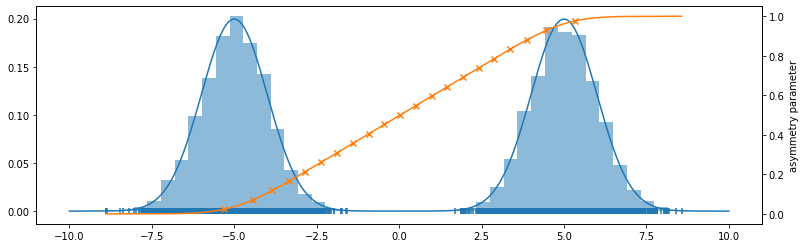

0.030318258132663


In [20]:
R = GMM(coeffs=[0.5, 0.5], params=[[-5, 1], [5, 1]])
N = 10000
SAMPLE = R.rvs(N)
GMM_X = np.linspace(-10, 10, 1000)
GMM_Y = R.pdf(GMM_X)
T = tauspace(21)
T_ = tauspace(999, endpoints=True)
E = expectile(SAMPLE, T)
E_ = expectile(SAMPLE, T_)

fig, (ax1) = plt.subplots(1, 1, figsize=(13, 4))
ax1.hist(SAMPLE, density=True, alpha=0.5, bins=42)
ax1.scatter(SAMPLE, np.zeros_like(SAMPLE), marker="|")
ax1.plot(GMM_X, GMM_Y, color="tab:blue")
ax2 = ax1.twinx()
ax2.set_ylabel("asymmetry parameter")
ax2.plot(E_, T_, color="tab:orange")
ax2.scatter(E, T, marker="x", color="tab:orange", zorder=3)
plt.show()
print(E[len(E)//2])

EXPORT['true distribution'] = {
    'pdf': (GMM_X, GMM_Y),
    'sample': (SAMPLE),
    'N': N,
    'minor expectiles': (E_, T_),
    'major expectiles': (E, T),
}

## Stability experiments

In [21]:
def shift_experiment(taus, imputer, sample=SAMPLE, n_iterations=100,
                     n_samples=None, cm=plt.cm.gist_rainbow, bins=None,
                     kde=None, **kwargs):
    if n_samples is None: n_samples = len(sample)
    print("imputation shift experiment with", imputer)
    print("n samples:    ", n_samples)
    print("n iterations: ", n_iterations)
    # record more expectiles than those provided
    full_taus = tauspace(999)
    expectiles = np.ndarray((n_iterations+1, 999))
    samples = np.ndarray((n_iterations, n_samples))
    sample0 = sample
    fits = []
    # perform experiment:
    expectiles[0] = expectile(sample, full_taus)
    for i in tqdm.trange(1, n_iterations+1):
        imputer.fit(expectile(sample, taus), taus, **kwargs)
        fits.append((imputer.τ, imputer.ε))
        sample = imputer.sample(n_samples)
        expectiles[i] = expectile(sample, full_taus)
        samples[i-1] = sample
    imputer.fit(expectile(sample, taus), taus, **kwargs)
    fits.append((imputer.τ, imputer.ε))

    # visualise:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.set_xlabel("expectile (ε)")
    ax1.set_ylabel("asymmetry (τ)")
    ax2.set_xlabel("sample point")
    ax2.set_ylabel("sample density")
    support_range = (min(sample0.min(), samples.min()),
                     max(sample0.max(), samples.max()))
    support = np.linspace(*support_range, 500)
    if bins is None: bins=np.linspace(*support_range, 100)
    for i in range(0, n_iterations+1, max(1, n_iterations//5)):
        ax1.plot(expectiles[i], full_taus,
                 label=f'after {i} iterations', color=cm(i/n_iterations))
        try:
            t, e = fits[i]
            ax1.scatter(e, t, marker="x", alpha=10/len(fits[i][0]),
                        color=cm(i/n_iterations))
        except:
            pass
        ax2.hist(samples[i-1] if i else sample0,
                 density=True, alpha=0.3, bins=bins,
                 label=f'after {i} iterations', color=cm(i/n_iterations))
        if kde is not None:
            kd = stats.gaussian_kde(samples[i-1] if i else sample0,
                                    bw_method=kde)
            ax2.plot(support, kd.pdf(support), color=cm(i/n_iterations))
    ax1.legend()
    ax2.legend()
    plt.show()
    
    # export
    export = {}
    for i in range(0, n_iterations+1):
        export[i] = {
            'iteration': i,
            'sample': samples[i-1] if i else sample0,
            'N': len(samples[i-1] if i else sample0), 
            'minor_expectiles': (expectiles[i], full_taus),
            'major_expectiles': (fits[i][1], fits[i][0]),
        }
    return export
    

### Deepmind's Naive imputer

imputation shift experiment with NaiveImputer()
n samples:     10000
n iterations:  5


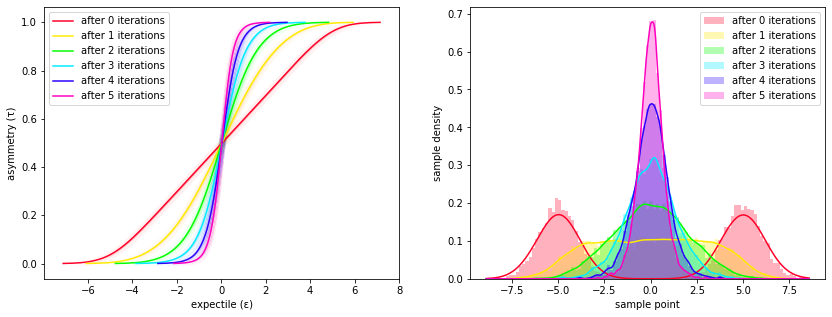

imputation shift experiment with NaiveImputer()
n samples:     10000
n iterations:  50


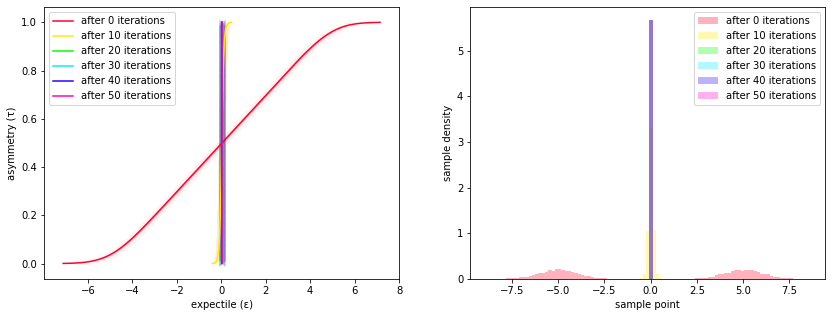

In [22]:
shift_experiment(tauspace(1001), imputers.NaiveImputer(), n_iterations=5, kde=0.12)
EXPORT['naive imputer'] = \
shift_experiment(tauspace(1001), imputers.NaiveImputer(), n_iterations=50)

imputation shift experiment with OptBasedImputer(self.method='root', self.start='bestof1000')
n samples:     11
n iterations:  5


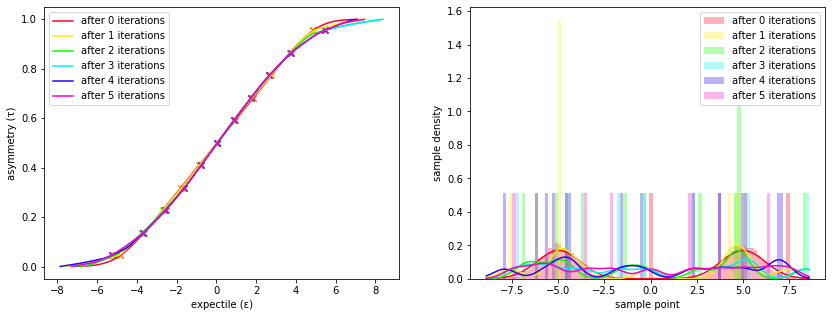

imputation shift experiment with OptBasedImputer(self.method='root', self.start='bestof1000')
n samples:     11
n iterations:  50


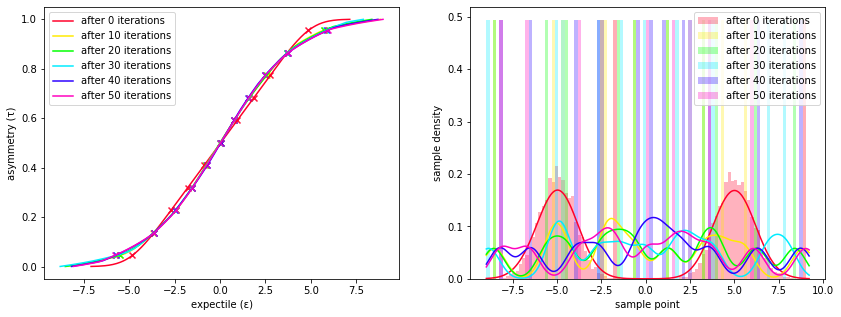

In [24]:
shift_experiment(tauspace(11), imputers.OptBasedImputer(), n_iterations=5, n_samples=11, kde=0.12)
EXPORT['opt-based imputer'] = \
shift_experiment(tauspace(11), imputers.OptBasedImputer(), n_iterations=50, n_samples=11, kde=0.12)

imputation shift experiment with DirectImputer(self.smooth_invert=True, self.exp_tails=True)
n samples:     10000
n iterations:  5


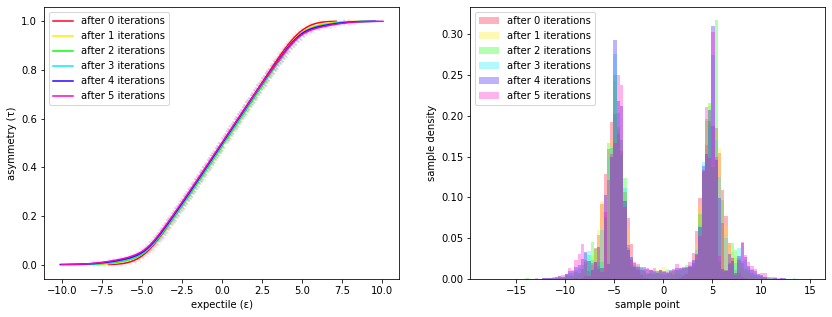

imputation shift experiment with DirectImputer(self.smooth_invert=True, self.exp_tails=True)
n samples:     10000
n iterations:  50


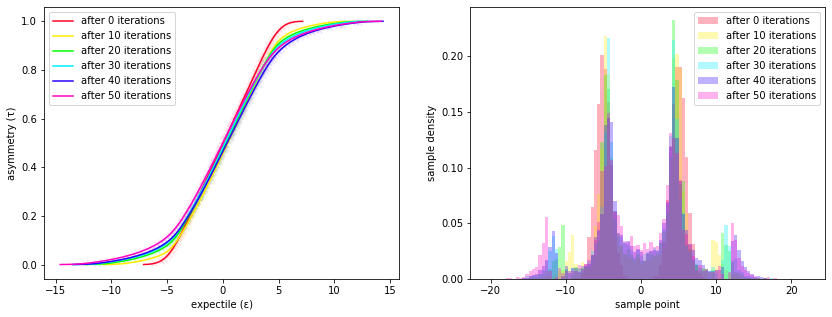

In [26]:
shift_experiment(tauspace(101), imputers.DirectImputer(smooth_invert=True, exp_tails=True),
                 n_iterations=5)
EXPORT['direct imputer'] = \
shift_experiment(tauspace(101), imputers.DirectImputer(smooth_invert=True, exp_tails=True),
                 n_iterations=50)

imputation shift experiment with InterpolatingImputer()
n samples:     10000
n iterations:  5


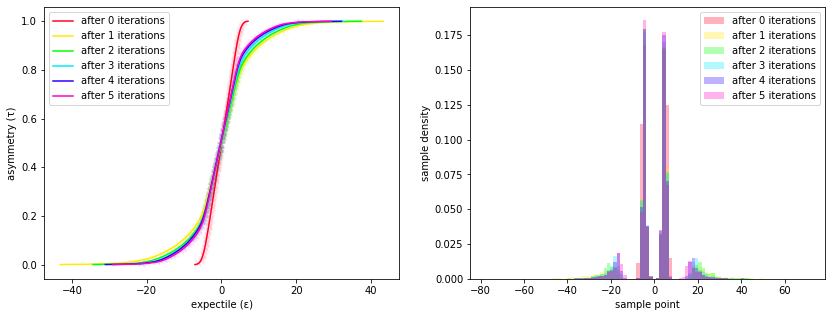

imputation shift experiment with InterpolatingImputer()
n samples:     10000
n iterations:  50


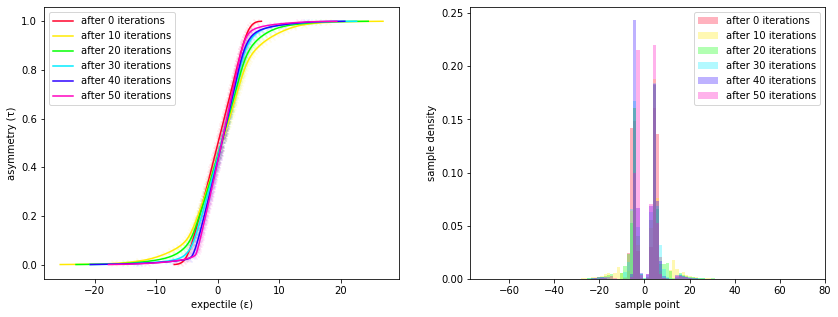

In [7]:
shift_experiment(tauspace(101), imputers.InterpolatingImputer(), n_iterations=5)
shift_experiment(tauspace(101), imputers.InterpolatingImputer(), n_iterations=50)

## Imputation *in*-stability---shift experiments *without* full tau ranges

We explore various expectile imputation strategies and their stability through repeated imputation.

In [27]:
def positive_shift_experiment(k, imputer, **kwargs):
    return shift_experiment(tauspace(k)[k//2:], imputer, i=0, **kwargs)

imputation shift experiment with DirectImputer(self.smooth_invert=True, self.exp_tails=True)
n samples:     10000
n iterations:  5


/Users/matt/Code/nsproj/imputers.py:19: RuntimeWarning: invalid value encountered in true_divide
  W /= W.sum(axis=-1, keepdims=True)


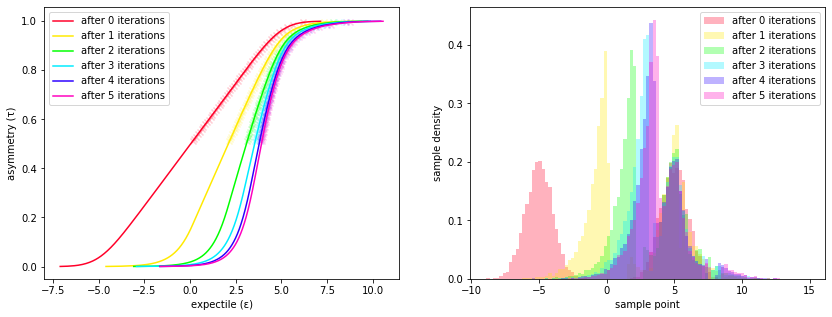

imputation shift experiment with DirectImputer(self.smooth_invert=True, self.exp_tails=True)
n samples:     10000
n iterations:  50


/Users/matt/Code/nsproj/imputers.py:19: RuntimeWarning: invalid value encountered in true_divide
  W /= W.sum(axis=-1, keepdims=True)


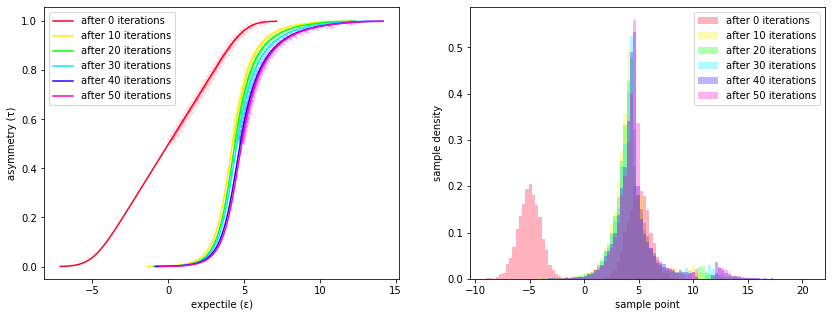

In [28]:
positive_shift_experiment(101, imputers.DirectImputer(smooth_invert=True, exp_tails=True), n_iterations=5)
EXPORT['direct imputer (half)'] = \
positive_shift_experiment(101, imputers.DirectImputer(smooth_invert=True, exp_tails=True), n_iterations=50)

imputation shift experiment with InterpolatingImputer()
n samples:     10000
n iterations:  5


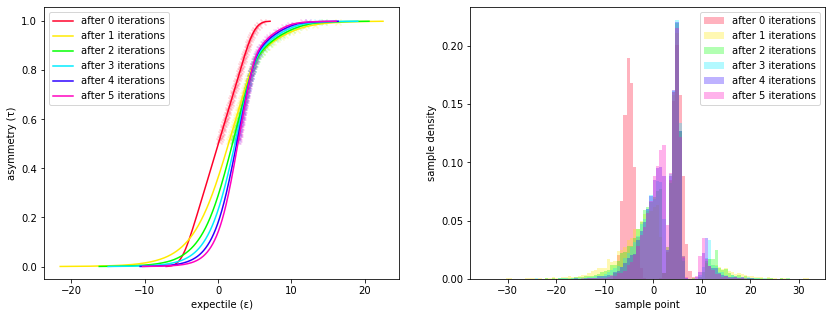

imputation shift experiment with InterpolatingImputer()
n samples:     10000
n iterations:  50


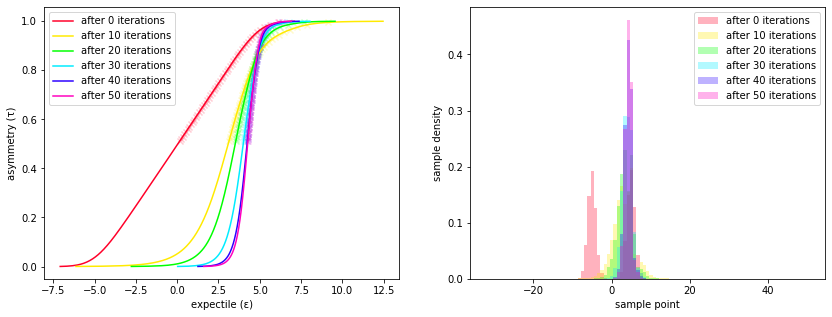

In [10]:
positive_shift_experiment(101, imputers.InterpolatingImputer(), n_iterations=5)
positive_shift_experiment(101, imputers.InterpolatingImputer(), n_iterations=50)

imputation shift experiment with OptBasedImputer(self.method='root', self.start='bestof1000')
n samples:     11
n iterations:  5


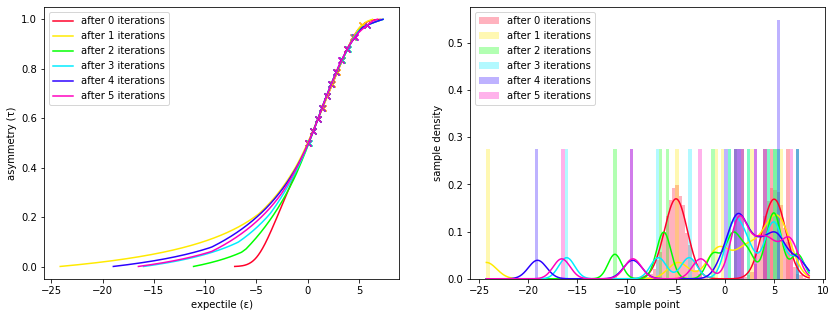

imputation shift experiment with OptBasedImputer(self.method='root', self.start='bestof1000')
n samples:     11
n iterations:  50


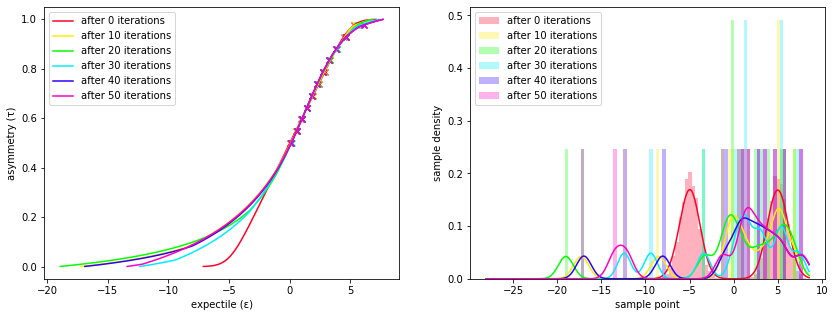

In [29]:
positive_shift_experiment(21, imputers.OptBasedImputer(), n_samples=11, n_iterations=5, kde=0.12)
EXPORT['opt-based imputer (half)'] = \
positive_shift_experiment(21, imputers.OptBasedImputer(), n_samples=11, n_iterations=50, kde=0.12)

In [31]:
print(list(EXPORT.keys()))

['true distribution', 'naive imputer', 'opt-based imputer', 'direct imputer', 'direct imputer (half)', 'opt-based imputer (half)']


In [32]:
import pickle

def save(data, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)
def load(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)
    
save(EXPORT, 'data/stability-data.pkl')